# **NBA Sports Betting Model**

Bu not defterinin amacı, takımların önceki sonuçları göz önüne alındığında bir NBA maçında Üst/Alt tahmin etmeye çalışmaktır. Bahis siteleri tarafından verilen çizgileri tahmin etmeyi beklemiyorum. Bununla birlikte, bu projenin asıl amacı, regresyon analizi anlayışımı geliştirmek ve yaygın uygulamalarla biraz pratik yapmaktır.

***Üst/Alt ne anlama geliyor?***

Üst/Alt, bahis sitesinin, sonucun belirtilen sayının üzerinde veya altında olması durumunda seçmeniz gereken bir sayı sağladığı sunulan bir bahis hattıdır. Bu bahis modeli, oyunun sonunda atılan toplam puan (her iki takımın toplamı) olan en yaygın alt/üst değerine atıfta bulunacaktır.

 Örneğin alt/üst değeri 225 ise ve sonucun bundan daha düşük olacağını düşünüyorsanız altını alırsınız. Daha sonra oyundan sonra A takımı 110 ve B takımı 105 (110 + 105 = 115) kazanır, çünkü 115 225'in altındadır.

In [23]:
pip install scrapy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import scrapy


In [25]:
gamesdata = pd.read_csv("games.csv")

point_total = gamesdata.PTS_home + gamesdata.PTS_away
gamesdata["point_total"] = point_total

*Sonra verilerimi 2011'de başlayacak şekilde kısıtladım -> şimdiki zaman*

In [26]:
gamesdata = gamesdata.loc[gamesdata.SEASON >= 2011 ]
gamesdata.sort_values(by=["GAME_DATE_EST"])
gamesdata = gamesdata.reset_index()

In [27]:
avgtotal_home = []

for ind in range(len(gamesdata)):
  date = gamesdata["GAME_DATE_EST"][ind]
  hteam = gamesdata["HOME_TEAM_ID"][ind]

  # Ev sahibi takım olduklarında
  match_stats = gamesdata.loc[      (gamesdata.GAME_DATE_EST < date) & (gamesdata.HOME_TEAM_ID == hteam)  ]
  
  # Ev sahibi takım 25 iç saha maçı
  if not match_stats.empty:
    prevgamescount = len(match_stats.index) # Kaç oyun oynandı
    if prevgamescount < 25:
      # 25'ten az varsa, bir önceki sezona geri dönün ve ortalamayı alın
      lastseas = gamesdata.loc[          (gamesdata.GAME_DATE_EST < date) & (gamesdata.HOME_TEAM_ID == hteam)      ]
      lastseas10 = lastseas.iloc[:25]
      avglast5home = lastseas.point_total.mean(axis=0)
    else:
      only5 = match_stats.iloc[:25]
      avglast5home = only5.point_total.mean(axis=0)

    avgtotal_home.append(avglast5home)

  # Bu liste veri çerçevesine bir sütun olarak eklenecektir


Bir keresinde her iki takım için önceki 50 maçın ortalamasını almıştım. Sonra bu iki sayının ortalamasını aldım. Buradaki fikir, takımın genellikle yüksek skorlu oyunlara sahip olup olmadığını geçmiş performansa dayalı olarak görebilmeniz gerektiğidir.

Daha sonra, her iki takımın ortalamasını alırsanız, oyunun yüksek veya düşük skorlu olup olmayacağını tahmin etmek için iyi bir değer elde etmelisiniz. Bu değer, sezonla birlikte modelimdeki en güçlü özellikler oldu:

In [ ]:
mean = ((gamesdata.avgpointtotal_away + gamesdata.avgpointtotal_home) / 2)
gamesdata["meanpointtotal"] = mean

# **Veri Kazıma**

Modelimin doğruluğunu karşılaştırabilmek için bir temel değer istiyorum. Bu yüzden, bahis çizgisinin ortalama mutlak hatasını hesaplamak için önceki bahis çizgisi verilerini kazımaya ve sonuçla karşılaştırmaya karar verdim. 

Bunu yapmak için scrapy kütüphanesini kullanıyorum. İşte web kazıyıcının kodu:

In [29]:
class tableSpider(scrapy.Spider):
  name = 'table'

  start_url = [
      "https://sportsdatabase.com/nba/query?output=default&sdql=date%2C+team%2C+site%2C+o%3Ateam%2C+total%2C++points%2C+o%3Apoints+%40season%3E2010&submit=++S+D+Q+L+%21++"
  ]

  def parse(self, response):
    for row in response.xpath('//*[@class="dataTables_wrapper no-footer"]//tbody/tr'):
      if row.xpath('td[3]//text()').extract_first() == "home":
        yield {
            'date' : row.xpath('td[1]//text()').extract_first(),
            'team' : row.xpath('td[2]//text()').extract_first(),
            'site' : row.xpath('td[3]//text()').extract_first(),
            'o:team' : row.xpath('td[4]//text()').extract_first(),
            'total' : row.xpath('td[5]//text()').extract_first(),
            'points' : row.xpath('td[6]//text()').extract_first(),
            'o:points' : row.xpath('td[7]//text()').extract_first(),
                    }

Buradan bahis çizgilerinin ortalama mutlak hatasını elde etmek kolaydı:

In [30]:
data = pd.read_csv("https://raw.githubusercontent.com/PerryGraham/Betting-Model-NBA/master/datascrape/bets.csv")

# Satırlarda home/away nedeniyle çiftler var, bu nedenle diğer tüm satırları kaldırın
data = data[data.site == "home"]

# Her iki takım için puanların toplanması
data["real_total"] = data["points"] + data["o:points"]

# Çizgi ile sonuç arasındaki farkın hesaplanması
data["error"] = data["real_total"] - data["total"]

# Hatayı mutlak değer haline getirme
data["error"] = data.error.abs()

# Çizgiler ve sonuç arasındaki ortalama mutlak hatanın hesaplanması
n = len(data)
total_error = data.error.sum()
mae_lines = total_error / n

print ("MAE over last 10 years", mae_lines)

MAE over last 10 years 13.42853888937936


<ipython-input-30-708e7b644d00>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["real_total"] = data["points"] + data["o:points"]
<ipython-input-30-708e7b644d00>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["error"] = data["real_total"] - data["total"]
<ipython-input-30-708e7b644d00>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

# **Preprocessing & EDA**

Takım id'lerini one-hot encode etmeye karar verdim, bu ev sahibi ve deplasman takımlarını idare etmenin en iyi yolu gibi görünüyor. Yine de veri çerçevesine çok fazla sütun ekliyor.

Sezon için, sadece 0'dan başlamak üzere ölçeklendirdim. Sonra eski sütunları ve takım başına atılan puanları düşürdüm çünkü bu, oyun bitene kadar bilinmiyor, bu da veri sızıntılarına neden olabilir.

In [31]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from sklearn import preprocessing

# Verileri okuyun
X_full = pd.read_csv("https://raw.githubusercontent.com/PerryGraham/Betting-Model-NBA/master/data/cleandata2.csv")
X_full["GAME_DATE_EST"] = pd.to_datetime(X_full["GAME_DATE_EST"],infer_datetime_format=True)
X_full = X_full.sort_values(by=["GAME_DATE_EST"], ascending=False)
X_full = X_full.reset_index()

# Etiket / One-Hot takım kimliklerini ve sezonu kodlar
le = preprocessing.OneHotEncoder()
le2 = preprocessing.LabelEncoder()
ohe_home = le.fit_transform(X_full[["HOME_TEAM_ID"]]).toarray()
ohe_away = le.transform(X_full[["VISITOR_TEAM_ID"]]).toarray()
X_full["SEASON"] = X_full["SEASON"] - 2010

# Eski sütunları bırak
X_full = X_full.drop(columns = [
    "HOME_TEAM_ID", "VISITOR_TEAM_ID", "PTS_home", "PTS_away", "GAME_DATE_EST", "index"], axis=1)

Burada, bunlardan faydalı bir özellik elde edip edemeyeceğimi görmek için ortalama puan toplamı sütunlarında birkaç farklı işlem denedim.

İkisi arasındaki farkın, modellerimde biraz daha iyi performans elde etmeme yardımcı olan güçlü bir özellik olduğu ortaya çıktı

In [32]:
# Test özellikleri:
X_full["diff"] = X_full["avgpointtotal_home"] - X_full["avgpointtotal_away"]
#X_full["diff"] = X_full["diff"]**2
#X_full["diff"] = X_full["diff"].abs()
#X_full["multi"] = X_full.apply(lambda row: row.avgpointtotal_home / row.avgpointtotal_away, axis=1)

#X_full["off_power_home"] = X_full["point_average_last10"] - X_full["away_point_againts_average_last10"]
#X_full["off_power_away"] = X_full["away_point_average_last10"] - X_full["point_againts_average_last10"]
#X_full["gap"] = X_full["off_power_home"].abs() + X_full["off_power_away"].abs()

In [33]:
X_full.head(5)

,SEASON,point_total,point_average_last10,point_againts_average_last10,away_point_average_last10,away_point_againts_average_last10,cgp,wins,losses,winpercent,...,losses_away,winpercen_away,hometeam-homewins,hometeam-awaywins,awayteam-homewins,awayteam-awaywins,avgpointtotal_home,avgpointtotal_away,meanpointtotal,diff
0,9,178.0,98.55,108.05,122.20,107.50,59,21,38,0.356,...,8,0.864,9,12,27,24,205.64,222.40,214.02,-16.76
1,9,266.0,116.65,109.30,107.55,107.90,59,40,19,0.678,...,23,0.617,24,16,28,9,226.24,216.72,221.48,9.52
2,9,251.0,112.35,109.50,115.95,107.40,59,40,19,0.678,...,17,0.712,23,17,23,19,219.00,221.72,220.36,-2.72
3,9,206.0,112.65,112.55,106.85,110.05,59,25,34,0.424,...,41,0.328,12,13,11,9,217.48,221.00,219.24,-3.52
4,9,236.0,120.80,117.30,116.20,109.40,59,26,33,0.441,...,13,0.776,12,14,21,24,227.04,224.28,225.66,2.76


Burada şimdiye kadarki verilerimizin düzenini görebiliriz. Bazı sütunların ne anlama geldiğini açıklayacağım:

***point_average_last10 - ev sahibi takımın son 10 maçta attığı ortalama sayıdır
points_againts_average_last10 - son 10 maçta ev sahibi takıma karşı atılan ortalama sayıdır
Sonraki iki sütun aynıdır ancak misafir takım içindir.***

Bu sütunlar, güçlü savunma takımlarını / güçlü hücum takımlarını belirlemenin bir yolu olarak işlev görmelidir (umarım mevcut oyunun sonucunu göstermelidir)

***cpg - mevcut oynanan maçlar (bu sezon kaç maçı tamamladıkları) (_away aynıdır ancak misafir takım için)***

son 4 sütun daha önce açıklanan sütunlardır

In [34]:
X_full.describe()

,SEASON,point_total,point_average_last10,point_againts_average_last10,away_point_average_last10,away_point_againts_average_last10,cgp,wins,losses,winpercent,...,losses_away,winpercen_away,hometeam-homewins,hometeam-awaywins,awayteam-homewins,awayteam-awaywins,avgpointtotal_home,avgpointtotal_away,meanpointtotal,diff
count,11915.000000,11915.000000,11915.000000,11915.000000,11915.000000,11915.000000,11915.000000,11915.000000,11915.000000,11915.000000,...,11915.000000,11915.000000,11915.000000,11915.000000,11915.000000,11915.000000,11915.000000,11915.000000,11915.000000,11915.000000
mean,4.934117,206.359295,100.741507,101.277327,100.718275,101.247986,38.852119,20.076290,18.776081,0.497770,...,18.735124,0.504076,11.566093,8.510197,11.823164,8.307176,201.261316,201.245986,201.253651,0.015331
std,2.463316,21.943288,5.806101,6.184010,5.794636,6.141684,25.445032,15.677251,13.778356,0.208152,...,13.736672,0.207207,9.028124,6.986531,9.047625,6.865404,9.153747,9.144523,7.344656,10.911044
min,1.000000,134.000000,83.300000,83.650000,83.500000,83.850000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,174.920000,174.920000,177.060000,-35.640000
25%,3.000000,191.000000,96.550000,96.900000,96.550000,96.750000,16.000000,7.000000,7.000000,0.364000,...,7.000000,0.371000,4.000000,3.000000,4.000000,3.000000,194.960000,194.960000,196.020000,-7.600000
50%,5.000000,205.000000,99.800000,101.500000,99.800000,101.500000,38.000000,17.000000,17.000000,0.500000,...,17.000000,0.509000,10.000000,7.000000,10.000000,7.000000,200.280000,200.280000,200.820000,-0.040000
75%,7.000000,221.000000,104.750000,105.850000,104.750000,105.850000,60.000000,30.000000,28.000000,0.636000,...,28.000000,0.639000,18.000000,13.000000,18.000000,13.000000,207.680000,207.680000,206.540000,7.635839
max,9.000000,329.000000,121.900000,123.300000,122.200000,122.300000,82.000000,73.000000,69.000000,1.000000,...,71.000000,1.000000,40.000000,34.000000,40.000000,34.000000,230.120000,229.440000,227.860000,36.000000


In [35]:
X_full.point_total.describe()

count    11915.000000
mean       206.359295
std         21.943288
min        134.000000
25%        191.000000
50%        205.000000
75%        221.000000
max        329.000000
Name: point_total, dtype: float64

Burada fark ettiğim bir şey, hedef değişkende çok fazla varyans olduğudur. Standart sapma ~22 ve Q1-Q3 aralığı 30'dur.

Tüm özellikler arasındaki korelasyonu görmek için kontrol edin. Beklendiği gibi özellikler arasında çok fazla korelasyon vardır. Modelleri/parametreleri seçerken bunu akılda tutmak önemlidir.

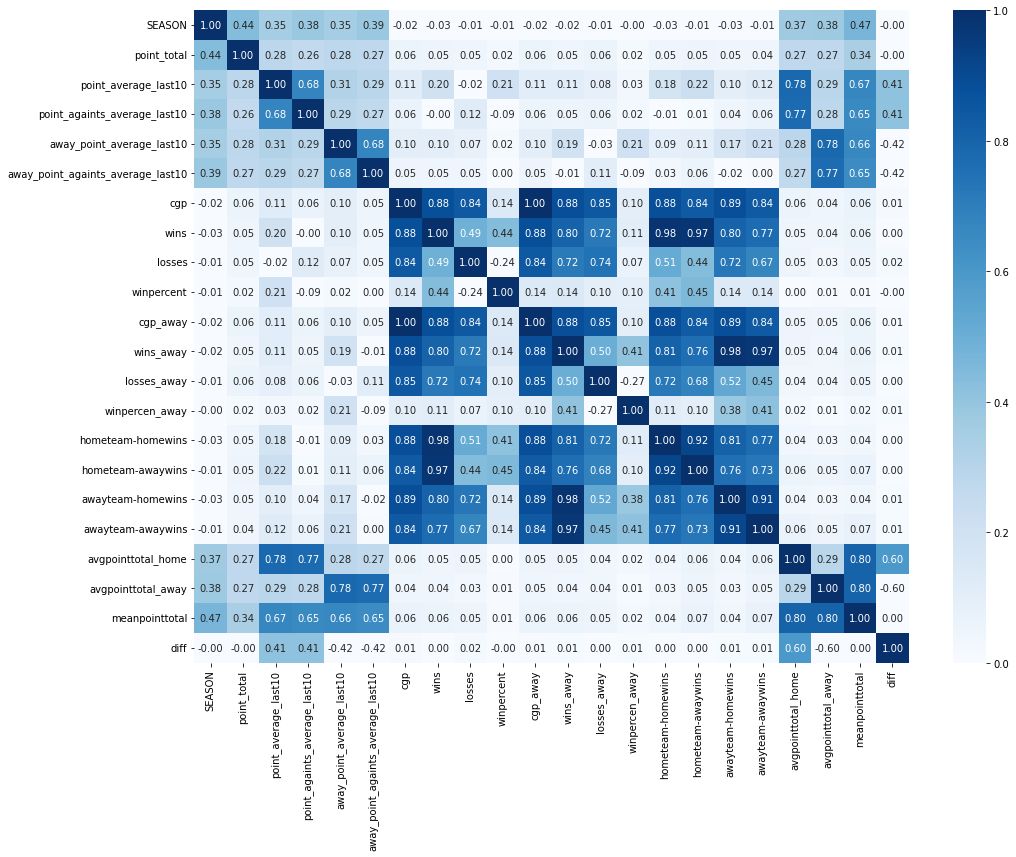

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 12))
sns.heatmap(X_full.corr(),
            cmap="Blues", annot=True, fmt='.2f', vmin=0);

Bazı yüksek korelasyonlu özellikler vardır, bunlar daha sonra ele alınacaktır. Hedefle en yüksek korelasyona sahip özellikler şunlardır: mevsim, meanotalpoints ve point_average_last10/away_points_average_last10

Tek sıcak kodlanmış sütunlara ekleme:

In [37]:
ohe_home_df = pd.DataFrame(ohe_home)
ohe_away_df = pd.DataFrame(ohe_away, columns=list("abcdefghijklmnopqrstuvwxyzABCD"))
X_full = pd.concat([X_full, ohe_home_df], axis=1)
X_full = pd.concat([X_full, ohe_away_df], axis=1)
print(X_full.shape)

(11915, 82)


In [38]:
X_full.head(5)

,SEASON,point_total,point_average_last10,point_againts_average_last10,away_point_average_last10,away_point_againts_average_last10,cgp,wins,losses,winpercent,...,u,v,w,x,y,z,A,B,C,D
0,9,178.0,98.55,108.05,122.20,107.50,59,21,38,0.356,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9,266.0,116.65,109.30,107.55,107.90,59,40,19,0.678,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9,251.0,112.35,109.50,115.95,107.40,59,40,19,0.678,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,9,206.0,112.65,112.55,106.85,110.05,59,25,34,0.424,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,9,236.0,120.80,117.30,116.20,109.40,59,26,33,0.441,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **Özellik Mühendisliği**

Birçok farklı özelliği denedikten, ortalamayı alırken kaç oyun geriye gideceğimi ayarladıktan sonra; işte elde edebildiğim en başarılı olanlar. 

Birçok özelliği kaldırmayı ve farklı kombinasyonlar denemeyi denedim. En iyi sonuçlar daha fazla veri ve özellik kullandığımda elde edildi.

Özellikler ve hedef arasındaki bazı ilişkilere bir göz atalım:

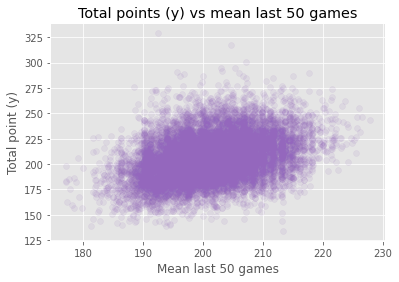

<Figure size 432x288 with 0 Axes>

In [39]:
import matplotlib.pyplot as plt 

with plt.style.context("ggplot"):
  plt.scatter(X_full.meanpointtotal, X_full.point_total, marker="o", alpha=0.1, color='#9467bd')
  plt.xlabel("Mean last 50 games")
  plt.ylabel("Total point (y)")
  plt.title("Total points (y) vs mean last 50 games")

fig1 = plt.figure();


Çok fazla gürültü var ve bu en güçlü korelasyon değil. Ancak, atılan toplam sayı ile her iki takımın oynadığı son 50 maçın ortalaması arasında net bir eğilim var.

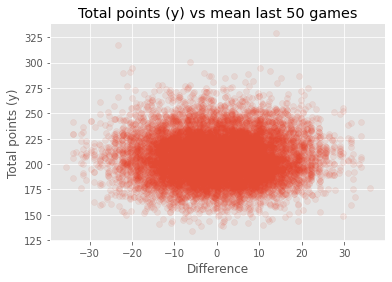

<Figure size 432x288 with 0 Axes>

In [40]:
with plt.style.context("ggplot"):
  plt.scatter(X_full["diff"], X_full.point_total, marker="o", alpha=0.1)
  plt.xlabel("Difference")
  plt.ylabel("Total points (y)")
  plt.title("Total points (y) vs mean last 50 games")

fig2 = plt.figure();

Bu grafik, iki takım arasında büyük bir fark olduğunda orta skorlu bir maça doğru hafif bir eğilim olduğunu göstermektedir. Ancak takımlar son 50 maç ortalamaları bakımından birbirlerine daha yakınsa, o zaman yüksek veya düşük skorlu bir maç olabilir.

Farkın mutlak değerini çizdiğinizde bu eğilimi görmek biraz daha kolay.

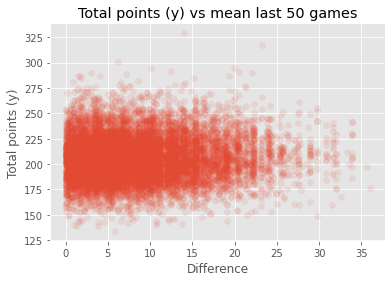

<Figure size 432x288 with 0 Axes>

In [41]:
with plt.style.context("ggplot"):
  plt.scatter(X_full["diff"].abs(), X_full.point_total, marker="o", alpha=0.1)
  plt.xlabel("Difference")
  plt.ylabel("Total points (y)")
  plt.title("Total points (y) vs mean last 50 games")

fig3 = plt.figure()

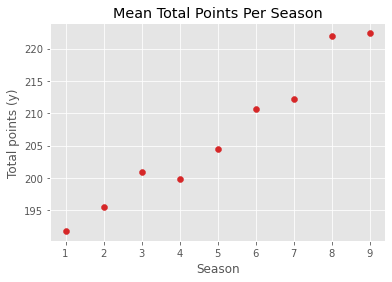

<Figure size 432x288 with 0 Axes>

In [42]:
#mean_df = X_full.copy()
#mean_df["target"] = y
season_avg = X_full.groupby(by=["SEASON"]).mean()

with plt.style.context("ggplot"):
  plt.scatter(season_avg.index, season_avg.point_total, color = "#d62728")
  plt.xlabel("Season")
  plt.ylabel("Total points (y)")
  plt.title("Mean Total Points Per Season")

fig4 = plt.figure();

# **Modeller**

Doğrulama için seçtiğim yöntem, rastgele karıştırma olmadan manuel 90:10 eğitim testi bölüşümü yapmaktı. Yani, eğitmek için eski verilerin tamamını ve doğrulamak için en yeni %10'u kullandığımızda. Bu, bu tür bir model için iyi bir doğrulama testi elde etmenin en basit yolu olduğu için seçildi. Çapraz doğrulama iyi bir fikir değildir çünkü o zaman bu modeli pratikte kullanacak olsaydınız erişemeyeceğiniz veriler üzerinde eğitim yapmış olurdunuz.

 Örneğin, 2019 verileri üzerinde çalışabilir ve bunun yüksek skorlu bir sezon olduğunu görebilirsiniz, o zaman 2019'un başlarındaki bir oyunu tahmin ederken olması gerekenden daha iyi sonuçlar elde edersiniz. Teoride en iyi yöntem, geleceği dışarıda bırakan bir doğrulama yöntemi olacaktır çünkü model pratikte bu şekilde çalışacaktır. Basitlik için 90:10 oranını kullandım. Bu da görev için yeterince iyi sonuçlar verecektir.



In [43]:
y = X_full["point_total"]
X_full = X_full.drop(columns=['point_total'])

test = len(X_full) - int(len(X_full)*0.9)

X_train = X_full.iloc[test:]
X_valid = X_full.iloc[:test]
y_train = y.iloc[test:]
y_valid = y.iloc[:test]


In [44]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error

EN = ElasticNet().fit(X_train,y_train)

pred_EN = EN.predict(X_valid)
mae_EN = mean_absolute_error(pred_EN, y_valid)
print ("mae",mae_EN)

mae 15.979896935372484


In [45]:
from sklearn.linear_model import Lasso

ls = Lasso().fit(X_train, y_train)

pred_ls = ls.predict(X_valid)
mae_ls = mean_absolute_error(pred_ls, y_valid)
print("mae", mae_ls)



mae 15.939184128274167


In [46]:
from sklearn.linear_model import Ridge

rg = Ridge().fit(X_train, y_train)

pred_rg = rg.predict(X_valid)
mae_rg = mean_absolute_error(pred_rg, y_valid)
print("mae", mae_rg)

mae 16.05975244647462


In [47]:
from sklearn.linear_model import TheilSenRegressor

ts = TheilSenRegressor().fit(X_train, y_train)
pred_ts = ts.predict(X_valid)
mae_ts = mean_absolute_error(pred_ts,y_valid)
print("mae",mae_ts)

mae 16.063875972037536


In [48]:
#lin reg 
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import cross_val_score

lin = LinearRegression(normalize=True, ).fit(
    X_train,y_train
)
pred_lin = lin.predict(X_valid)
mae_lin = mean_absolute_error(pred_lin, y_valid)
print("mae", mae_lin)

mae 16.0638069306444


In [49]:
from sklearn.neural_network import MLPRegressor

regr = MLPRegressor(random_state=1, max_iter=1000).fit(
    X_train, y_train
)

pred_mlp = regr.predict(X_valid)
mae_regr = mean_absolute_error(pred_mlp, y_valid)
print("mae",mae_regr)

mae 16.590031854345042


In [50]:
import xgboost as xgb

xg = xgb.XGBRegressor(
    booster="gblinear",
    objective="reg:squarederror",
    base_score="1",
    eval_metric="cox-nloglik"
).fit(X_train,y_train)
pred_xg = xg.predict(X_valid)
xg_regr = mean_absolute_error(pred_xg, y_valid)

print("mae", xg_regr)
print("done")

mae 16.039652165150482
done


Her seferinde geçen sezonun ortalamasını tahmin etmek için MAE'yi hesapladık.

In [51]:
error = []
mean_last_season = season_avg.iloc[6,0]
for i in y_valid:
    error.append(abs(mean_last_season - i))
mae_mean = sum(error) / len(error)

print(mae_mean)
print(mean_last_season)

17.8650445808526
212.14544138929088


Parametrelerin hiperoptimizasyonu ile bir model koleksiyonunu denemek için hpsklearn kütüphanesini kullanalım :

In [52]:
pip install hpsklearn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 KB 8.3 MB/s eta 0:00:00
  Created wheel for hpsklearn: filename=hpsklearn-0.1.0-py3-none-any.whl size=23913 sha256=adfd9b2345c81c5c7fc961e6d502ddeef63a7bba79f63e5717fc147d6397f1a7
  Stored in directory: /root/.cache/pip/wheels/ed/78/df/b51d66188f755e2c237b6bcbe8f0ed408e2508eb648814d6fb
Successfully built hpsklearn


In [53]:
pip install --upgrade hpsklearn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from hpsklearn import HyperoptEstimator, any_regressor
from hyperopt import tpe

estim = HyperoptEstimator(regressor=any_regressor("svr"))

estim.fit(X_train.values, y_train.values)

print(estim.best_model())

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_testing = scaler.fit_transform(X_train)
X_testing_valid = scaler.transform(X_valid)

In [ ]:
xg1 = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       colsample_bylevel=0.8886553695663921, colsample_bynode=1,
                       colsample_bytree=0.6068338278675369, gamma=0.0017889282555567038,
                       gpu_id=-1, importance_type='gain', interaction_constraints='',
                       learning_rate=0.0013963222902296055, max_delta_step=0, max_depth=7,
                       min_child_weight=19, monotone_contraints='()',
                      n_estimators=5400, n_jobs=0, num_parallel_tree=1,
                       objective='reg:linear', random_state=1,
                       reg_alpha=0.22448614695919908, reg_lambda=2.9482948529431052,
                       scale_pos_weight=1, seed=1, subsample=0.8571414026048771,
                       tree_method='exact', validate_parameters=1, verbosity=None).fit(X_testing,y_train)

pred_xg1 = xg1.predict(X_testing_valid)
xg1_regr = mean_absolute_error(pred_xg1, y_valid)
print("mae", xg1_regr)

                



# **Sonuçlar**



In [ ]:
results = {"Model" : ["ElasticNet" , "LinearRegression",
                      "MRegression", "XGBoost",
                      "Lasso", "Ridge", "TheilSen",
                      "Betting lines", "Guessing the mean",
                      "HyperoptEstimator"],
           "MAE Score": [mae_EN,mae_lin,
                         mae_regr, xg_regr, mae_ls,
                         mae_rg, mae_ts, mae_lines,
                         mae_mean, xg1_regr]}

result_df = pd.DataFrame(data=results)
result_df = result_df.sort_values(by=["MAE Score"])
print(result_df.to_string(index=False))


```
          Model  MAE Score
     Betting lines  13.428539
 HyperoptEstimator  15.707999
             Lasso  15.939184
        ElasticNet  15.979897
           XGBoost  16.022314
          TheilSen  16.033545
  LinearRegression  16.052512
             Ridge  16.059752
     MLPRegression  16.590032
 Guessing the mean  17.865045
```



***En iyi performans gösteren, Aşırı Optimize Edilmiş XGBoostRegressor'durModellerin doğruluğunun yorumlanması:***

In [ ]:
bttm = (1 - (xg1_regr / mae_mean))*100
wttl = (1 - (mae_lines / xg1_regr))*100
print("The model is {:.0f}% better than guessing the mean".format(bttm))
print("The model is {:.0f}% worse than the betting lines".format(wttl))



```
The model is 12% better than guessing the mean
The model is 15% worse than the betting lines
```



***Hedef değişkende o kadar çok gürültü vardır ki, bir NBA maçında atılan toplam sayıları tahmin etmek kolay değildir. Geçmiş performansları sayı toplamı için bir tahminci olarak kullanmak çok iyi çalışmaz.***

**"Geçen maçta 130 sayı attılar, yine yüksek olacaktır" - bu veriler bunun açıkça hatalı bir ifade olduğunu göstermektedir. Bahis sitesindeki en iyi modellerin bile ortalama mutlak hatası 13,40 puan.**

*Model tahminlerinin görselleştirilmesi:*

In [ ]:
import numpy as np
with plt.style.context("ggplot"):
  plt.scatter(range(len(pred_xg1)), pred_xg1, marker="o", alpha=0.3, color = "#0066ff")
  plt.xlabel("Games")
  plt.ylabel("Estimated total points (y)")
  plt.title("Best Model Predictions")
fig6 = plt.figure();

               Best Model Predictions
               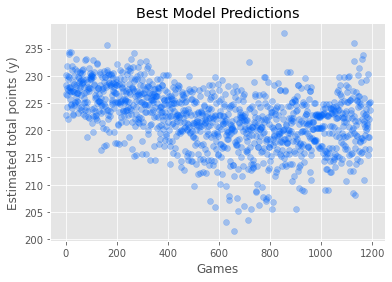



***Tahminlerin neden bu şekilde göründüğünün bir açıklaması, ilk ~400 maçın 2018 sezonundan ve geri kalanının 2019 sezonundan olmasıdır.***

*Gerçek sonuçların görselleştirilmesi:*

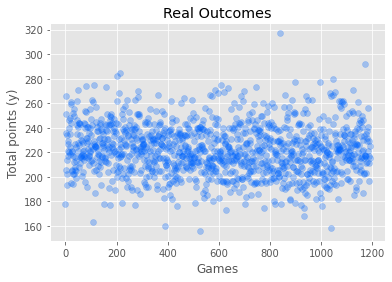

<Figure size 432x288 with 0 Axes>

In [64]:
with plt.style.context("ggplot"):
    plt.scatter(range(len(y_valid)), y_valid, marker="o", alpha=0.3, color="#0066ff")
    plt.xlabel("Games")
    plt.ylabel("Total points (y)")
    plt.title("Real Outcomes")
fig7 = plt.figure();

***Benzer görünüyorlar ancak x ekseni ölçeği gerçek sonuçlar grafiği için çok daha büyük.***

***En iyi modelimizin gerçek sonuçtan daha yüksek mi yoksa daha düşük mü tahmin ettiğini görmek için mutlak değeri almadan ortalama hatayı hesaplayabiliriz:***

In [ ]:
ls = []
for i in range(len(pred_ts)):
    ls.append(pred_xg1[i] - y_valid.iloc[i])
print ("Average Error of model:",sum(ls))
with plt.style.context("ggplot"):
    plt.scatter(range(len(ls)), ls, marker="o", alpha=0.3, color="#ff0000")
    plt.xlabel("Games")
    plt.ylabel("Prediction-Outcome Difference")
    plt.title("Error")
fig7 = plt.figure();

`Average Error of model: 18.774749755859375`

                   Error

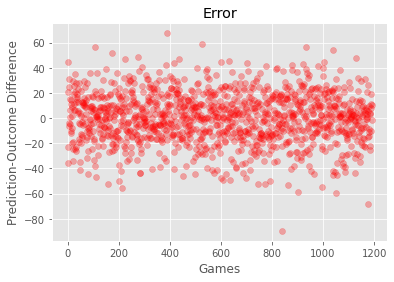

***Pozitif bir değer, modelin ortalama olarak gerçek sonuçtan daha yüksek bir tahminde bulunduğu anlamına gelir. Bu bazen modelin ne yaptığını görmek ve buna göre ayarlama yapmak için aydınlatıcı olabilir.***

***Negatif hata değerlerinin pozitif değerlerden daha geniş bir alana yayıldığına dikkat edin, bunun nedeni uzatma maçlarıdır.***

**Things I would have done differently if I were to do this again:**

▶ Sadece bir takım seçin, maçlarının toplam puanlarını tahmin etmeye çalışın. Her takım ve her maç yerine. Belki bu sayede daha fazla özellik keşfedebilir ve o takımın ve eşleşmelerin belirli eğilimlerine odaklanabilirim.

▶ Uzatmaya giden maçları belirleyin ve normal süre sona erdiğinde toplam puana sahip olun. Bu, bazı uzatma sonuçları önyargılarını azaltmaya yardımcı olabilir.

Hepinize okuduğunuz için teşekkürler
